In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 

from utils import mlp,train_test_model
from utils.scp_utils.scp import SCP
from utils.ewc_utils.onlineEWC import OnlineEWC
from utils.mas_utils.mas import MAS

from data.permuted_MNIST import get_permuted_mnist

import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from IPython import display
import time

In [2]:
import os
if not os.path.isdir('saved_models/'):
    os.mkdir('saved_models/')

## Set configurations

In [3]:
epochs = 20
lr = 1e-4 
batch_size = 100 
input_size = 784
hidden_sizes = [1024,512,256]
output_size = 10
num_task=2
activation='ReLU'
device='cuda:1'

## Load dataset

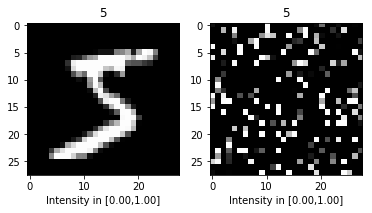

In [4]:
train_loader, test_loader = get_permuted_mnist(num_task,batch_size)

fig,ax=plt.subplots(1,num_task,figsize=(num_task*3,3))
for i in range(num_task):
    iter_data=iter(train_loader[i])
    image,label=iter_data.next()
    I=np.reshape(image.data[0,...].numpy(),(28,28))    
    ax[i].imshow(I,cmap='gray')
    ax[i].set_title(label.data[0].numpy())
    ax[i].set_xlabel("Intensity in [%.2f,%.2f]"%(I.min(),I.max()))
plt.show()

In [5]:
## define a MLP model
model=mlp.MLP(input_size=input_size,output_size=output_size,
              hidden_size=hidden_sizes,activation=activation,
              device=device).to(device)
optimizer = torch.optim.Adam(params=model.parameters(),lr=lr)

In [6]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Absolute Value of Gradient', artist='skolouri',
                comment='This movie demonstrate the absolute value of the gradient as a function of training iterations!')
writer = FFMpegWriter(fps=15, metadata=metadata)

## First we perform sequential learning with standard MLP 

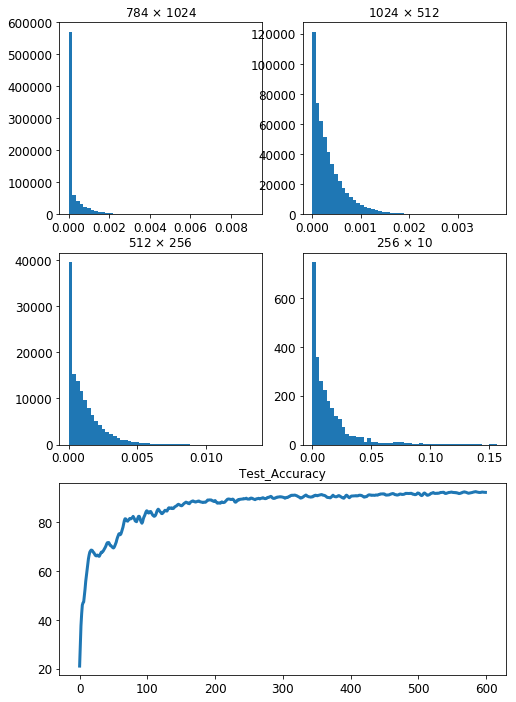

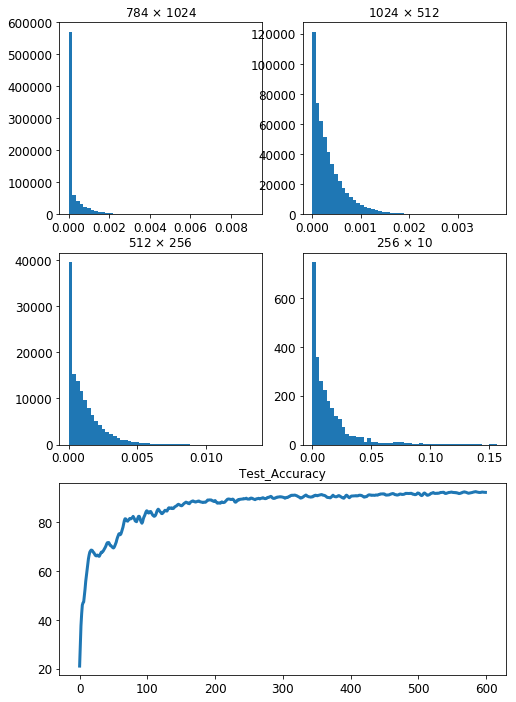

In [7]:
model.train()
criterion=nn.CrossEntropyLoss()
test_accuracy=list()

fig,axs=plt.subplots(3,2,figsize=(8,12))
gs = axs[2, 1].get_gridspec()
# remove the underlying axes
for ax in axs[-1, :]:
    ax.remove()
axbig = fig.add_subplot(gs[-1, :])
axbig.set_xlabel('Iterations',fontsize=12)
with writer.saving(fig, "./grads_ReLU.mp4", 100):
    for img, target in train_loader[0]:
        model.train()
        img, target = img.to(device), target.type(torch.LongTensor).to(device)
        optimizer.zero_grad()    
        output=model(img)
        loss = criterion(output, target)        
        loss.backward()
        optimizer.step()
        test_acc=0
        model.eval()
        for timg,ttarget in test_loader[0]:
            timg, ttarget = timg.to(device), ttarget.type(torch.LongTensor).to(device)
            output=torch.argmax(model(timg),1)
            test_acc+=(1.*(output==ttarget)).sum().item()
        test_accuracy.append(test_acc/float(len(test_loader[0])))
                             
                             
        for i,p in enumerate(model.parameters()):    
            axs[i//2,i%2].cla()
            axs[i//2,i%2].hist(torch.abs(p.grad.detach().reshape(-1)).cpu().numpy(),bins=50)
            axs[i//2,i%2].set_title(r'%d $\times$ %d'%(p.shape[1],p.shape[0]),fontsize=12)
            axs[i//2,i%2].tick_params(axis='both', which='major', labelsize=12)    

        axbig.cla()
        axbig.plot(test_accuracy,linewidth=3)
        axbig.tick_params(axis='both', which='major', labelsize=12)    
        axbig.set_title('Test_Accuracy',fontsize=12)                     
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(1e-2) 
        writer.grab_frame()